In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import math
from sklearn.model_selection import train_test_split
from collections import defaultdict

np.random.seed(123)

In [3]:
#data_root = 'data/train_1000_10'
data_root = 'data/train_700_28'
#data_root = 'data/train_1000_28'

truth_file = f'{data_root}/truth.dsv'

In [4]:
# load data
dataset = np.genfromtxt(truth_file, delimiter=':', dtype=np.dtype('<U12'), encoding='utf-8')
files, labels = np.split(dataset, 2, 1)
# flatten to a single vector
labels = labels.flatten()
files = files.flatten()

print(f'Labels shape: {labels.shape}')
print(f'Files shape: {files.shape}')

Labels shape: (700,)
Files shape: (700,)


In [5]:
def load_img(file_name):
    # open the image
    img = Image.open(file_name)
    # convert to grayscale to have a single dimension
    gray_scale = ImageOps.grayscale(img)
    # convert to numpy
    arr = np.asarray(gray_scale, dtype='float64')
    # convert to a single vector
    return arr.flatten()

In [6]:
# load image as a single vector
images = np.array([load_img(f'{data_root}/{x}') for x in files])

print(f'Images shape: {images.shape}')
samples, image_pixels = images.shape
print(f'Samples: {samples}x')
# we assume that the images are squares
image_size = int(math.sqrt(image_pixels))
print(f'Image size: {image_size}px')

Images shape: (700, 784)
Samples: 700x
Image size: 28px


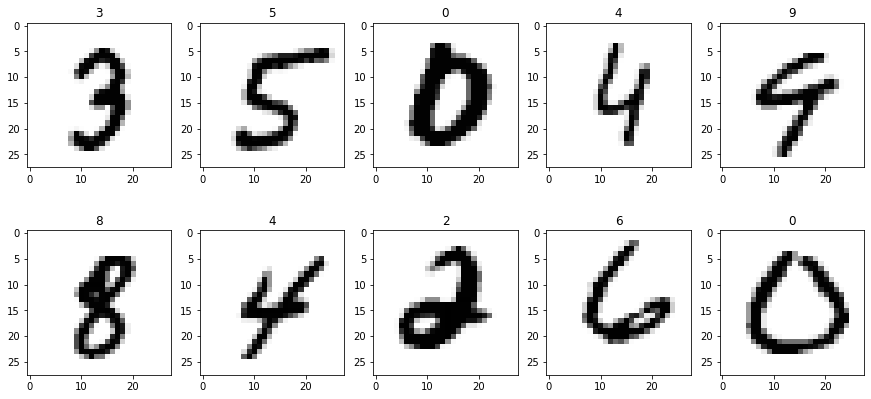

In [7]:
to_plot = 10
per_row = 5
fig = plt.figure(figsize=(15, 7))
for i in range(to_plot):
    ax = fig.add_subplot(int(to_plot / per_row), per_row, i+1)

    sample_idx = np.random.randint(0, len(images))
    img = images[sample_idx]
    img_size = int(math.sqrt(img.shape[0]))
    
    ax.title.set_text(labels[sample_idx])
    
    plt.imshow(img.reshape((img_size, img_size)), cmap='gray')
    
plt.show()

In [17]:
class Bayes:
    """
    Taking an image as a feature and a true value as a class.

    P(class | image) = (P(image | class) * P(class)) / P(image)
    """

    def __init__(self, X_train, y_train):
        # X - values, train vector
        self.X_train = X_train
        # y - labels, train labels
        self.y_train = y_train
        # find all unique classes
        self.classes = np.unique(y_train)
        # compute how many samples do we have
        self.n_s, self.n_f = X_train.shape
        self.n_c = len(self.classes)
        # structure for storing features means
        self.mean = defaultdict(lambda: np.zeros(self.n_f))
        # structure for storing variance of features
        self.variance = defaultdict(lambda: np.zeros(self.n_f))
        # how probable is the class given the data
        self.class_probability = defaultdict(lambda: 0.0)

        # this is here because otherwise we divide by zero due to the completely white/black pixels
        # so we add variance to all data -- using 10, we still divided by zero,
        # 100 was working, but 1000 was giving us best results while training the data
        # on provided datasets
        self.additional_variance = 1000

        self.__train()

    def __train(self):
        # iterate through all classes and compute means and variances
        for c in self.classes:
            # get all data with the same class
            X_c = self.X_train[self.y_train == c]
            # compute probability of a class c
            self.class_probability[c] = len(X_c) / len(self.X_train)
            # and compute mean and variance
            self.mean[c] = X_c.mean(axis=0)
            self.variance[c] = X_c.var(axis=0) + self.additional_variance

    def predict(self, single_x):
        # set default values
        mx, probable_c = -math.inf, None
        # go through all classes and compute
        for c in self.classes:
            # compute P(image | class)
            # we relax our problem a bit and we assume that the pixels in the image are independent
            # so here instead of having a single pixel as a feature, we just use mean and variance of the
            # whole image to represent the normal distribution, thus reducing the problem
            # here we need to compute density of the normal distribution
            dst = 1 / np.sqrt(2 * np.pi * self.variance[c])
            es = np.exp(-((single_x - self.mean[c]) ** 2) / (2 * self.variance[c]))
            # and now we have P(image | class)
            p_image_class = dst * es
            # and we compute the final probability -> we use smoothing, because
            # currently we're multiplying together potentially very small values
            # which is not great with floating point numbers -> however,
            # class maximizing P also maximizes log(P) so we can switch to using log probabilities
            # another "hack" we made here is that we do not add "+ np.log(self.class_probability[c])"
            # as we assume that all classes have same probability in the dataset (which might or not might be true,
            # but it gives us better results on data provided by the teachers)  
            p_log = np.sum(np.log(p_image_class))
            # select higher probability
            if p_log > mx:
                mx, probable_c = p_log, c

        return probable_c

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, labels)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (525, 784)
y_train shape: (525,)
X_test shape: (175, 784)
y_test shape: (175,)


In [19]:
b = Bayes(X_train, y_train)

predictions = np.array([b.predict(x) for x in X_test])
matches = len(predictions[predictions == y_test])

print(f'Performance: {matches / len(predictions)}')

Performance: 0.76
